# Importing the Relevant Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
import warnings
warnings.filterwarnings("ignore")

Loading the Dataset and setting the Index frequency to Month Start

In [37]:
df = pd.read_csv("./Data/HospitalityEmployees.csv", index_col = "Date", parse_dates = True)
df.head()
df.index.freq = "MS"

In [38]:
df.head()

,Employees
Date,
1990-01-01,1064.5
1990-02-01,1074.5
1990-03-01,1090.0
1990-04-01,1097.4
1990-05-01,1108.7


<Axes: xlabel='Date'>

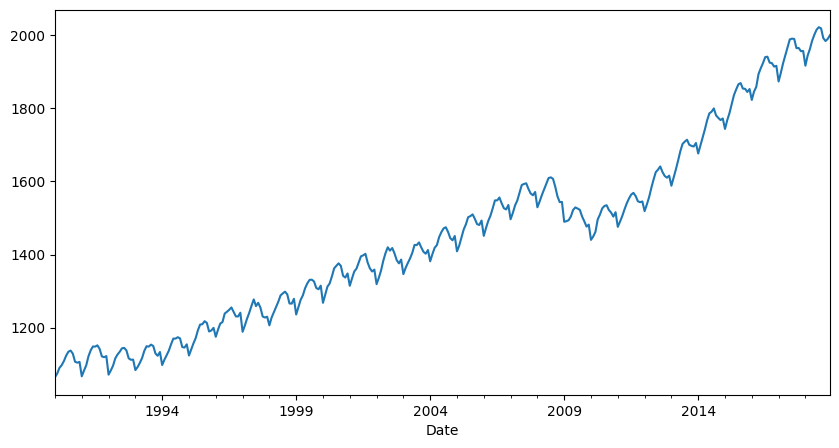

In [39]:
df["Employees"].plot(figsize = (10,5))

Checking the data for seasonality and trend 

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

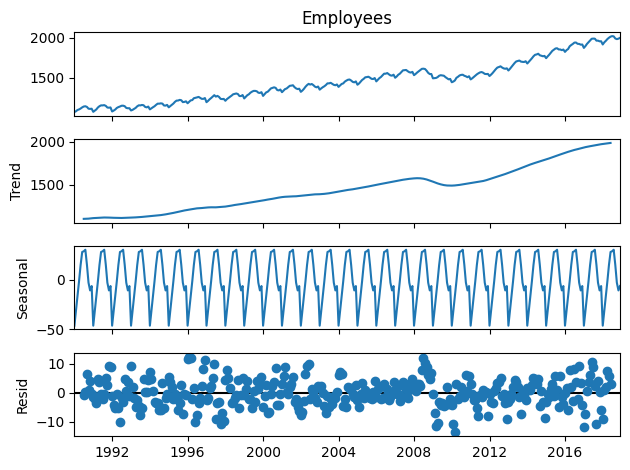

In [41]:
seasonal_decompose(df["Employees"]).plot();

In [42]:
from statsmodels.tsa.stattools import adfuller

In [43]:
adf_test = adfuller(df["Employees"])

In [44]:
print(f"ADF-Statistic: {adf_test[0]}")

ADF-Statistic: 0.901284423556976


In [45]:
print(f"p-value: {adf_test[1]}")

p-value: 0.9931070655289933


A p-value of greater than alpha(0.05) denotes that we do not reject the Null Hypothesis and conclude that the given data has non-stationarity

Setting the test data equal to last 12 months of the original data, to check for the model's performance

In [46]:
len(df)

348

In [47]:
train = df[:336]
test = df[336:]

Running Auto ARIMA on the training data to check for the best values for the orders(p,d,q) for the model

In [48]:
from pmdarima import auto_arima

In [49]:
auto_arima(train["Employees"], seasonal = True, m = 12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Fri, 09 May 2025   AIC                           2128.116
Time:                                      00:13:49   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9242      0.043     21.279      0.000       0.839       1.009
ma.L1         -0.9584      0.070    -13.597      0.000      -1.097      -0.820
ma.L2          0.1497      0.061      2.446      0.014       0.030       0.270
ar.S.L12       0.9973      0.001    729.145      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.145      0.000      -0.838      -0.666
sigma2        28.7712      1.685     17.075      0.000      25.469      32.074
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.34
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Training the SARIMAX model on the training set

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [51]:
results = SARIMAX(train["Employees"], order = (1,1,2), seasonal_order = (1,0,1,12)).fit()

In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Fri, 09 May 2025   AIC                           2128.116
Time:                                      00:13:58   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9242      0.043     21.279      0.000       0.839       1.009
ma.L1         -0.9584      0.070    -13.597      0.000      -1.097      -0.820
ma.L2          0.1497      0.061      2.446      0.014       0.030       0.270
ar.S.L12       0.9973      0.001    729.145      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.145      0.000      -0.838      -0.666
sigma2        28.7712      1.685     17.075      0.000      25.469      32.074
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.34
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Predicting the values from the trained model for the next 12 months and then checking with the actual test values through metrics(Root Mean Square)

In [53]:
start = len(train)
end = len(train) + len(test) - 1

In [54]:
predictions = results.predict(start, end, typ = "levels").rename("Predictions")

Here, we used (typ = "levels") to get the predictions on the original scale and not on the differenced scale

<Axes: xlabel='Date'>

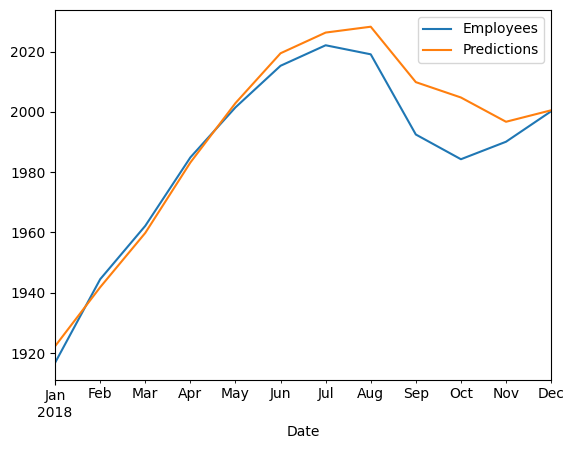

In [55]:
test["Employees"].plot(legend = True)
predictions.plot(legend = True)

In [56]:
from sklearn.metrics import root_mean_squared_error

In [57]:
root_mean_squared_error(test["Employees"], predictions)

8.809852291976176

In [58]:
test["Employees"].mean()

1986.125

Comparing the mean value of the Employees column with the Root Mean Square Error

# Training the model on the entire dataset

In [59]:
start = len(df)
end = start + 11

In [60]:
model = SARIMAX(df["Employees"], order = (1,1,2), seasonal_order = (1,0,1,12), m = 12).fit()

Predicting values for 12 months into the unknown future, using the SARIMAX model trained on the entire dataset

In [61]:
fcast = model.predict(start, end, typ = "levels").rename("Forecast")

In [62]:
fcast

2019-01-01    1963.876647
2019-02-01    1986.818543
2019-03-01    2006.000361
2019-04-01    2030.336404
2019-05-01    2050.317692
2019-06-01    2067.143764
2019-07-01    2074.924607
2019-08-01    2076.489030
2019-09-01    2056.900091
2019-10-01    2051.844417
2019-11-01    2047.930903
2019-12-01    2053.896614
Freq: MS, Name: Forecast, dtype: float64

<Axes: xlabel='Date'>

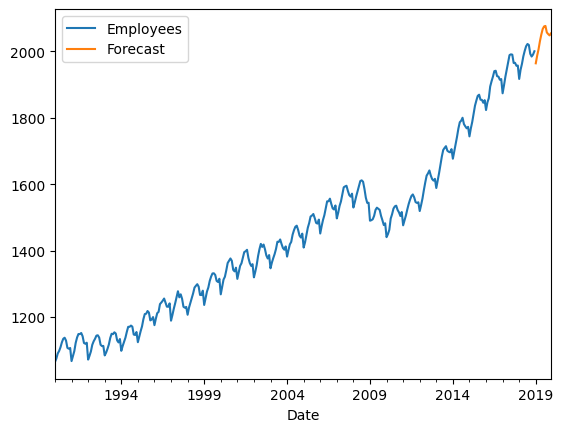

In [63]:
df["Employees"].plot(legend = True)
fcast.plot(legend = True)